### Code setup

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")
from IPython.display import HTML
from matplotlib import animation
%matplotlib inline

# Don't tinker, or do
#%matplotlib nbagg
# from matplotlib import rcParams
#rcParams['font.family']='sans-serif' 
#rcParams('font', serif='Helvetica Neue') 
# rcParams['text.usetex']= True 
#rcParams.update({'font.size': 22})

## Solving initial (-boundary) value problems
Time is something we all have to deal with and manage. Within the domain of scientific applications, this usually defaults to solving a (system of) initial value problem, specified in the following form:
$$ \frac{\partial \mathbf{u}}{\partial t} = \mathbf{F}(\mathbf{u}, t)$$
as a partial differential equation (PDE). As we will see, on numerical discretization modifies the above PDE into a manageable (computable) form, wherein
$$ \mathbf{u}^{n+1} = \sum_{i=0}^{k} \alpha_i \mathbf{u}^{n-i} + \sum_{j=0}^{r} \beta_j \frac{\partial \mathbf{u}^{n-j}}{\partial t} $$
which for $k=1$ and $r=0$ looks something along these lines:
$$ \mathbf{u}^{n+1} = \alpha_0 \mathbf{u}^{n} + \alpha_1 \mathbf{u}^{n-1} + \beta_0 \frac{\partial \mathbf{u}^{n}}{\partial t} $$
which takes the current ($n$) and past ($n-1$) information to predict states in the next (future, $n+1$) iterations.

Notice that $\mathbf{F}(\mathbf{u}, t)$ can also involve solving a boundary value problem, similar to our soft mechanics equations.

In [2]:
class TimeStepper(object):
    """ Class for wrapping a timestepper function with other goodies
    """
    def __init__(self, i_x, i_v, i_dt, i_T):
        """ Initialize the timestepper
        """
        # What forcing function are we using?
        self.forcing = None

        # What timestepping algorithm are we using?
        self.timestepper = None

        self.nsteps = int(i_T/i_dt)
        self.dt = i_dt

        if len(i_x) == len(i_v):
            # Same length, corresponding to index, data makes sense
            self.ndim = len(i_x)
            self.x = np.zeros((self.nsteps, self.ndim))
            self.v = np.zeros((self.nsteps, self.ndim))
            
            # Set initial values
            self.x[0] = np.array(i_x)
            self.v[0] = np.array(i_v)
        else:
            raise RuntimeError('Length of initial velocity and position \
            not matching')

    def set_forcing_function(self, t_func):
        """ Set forcing function to be used 
        """
        if type(t_func) is not str:
            try:
                # If not string, try and evaluate the function
                t_func(x[0])
                # If the function works, set this function as forcing
                self.forcing = t_func
            except:
                raise RuntimeError('Provided function cannot be evaluated')
        else:
            if t_func=="harmonic":
                def harmonic(x):
                    return -x
                self.forcing = harmonic
        
    def error_norm(self):
        """  For testing convergence, defined as a special function """
        if self.forcing.__name__ == 'harmonic':
            time_arr = np.arange(0.0, self.dt*self.nsteps, self.dt)
            analytical_solution = self.x[0, :]*np.exp(-time_arr.reshape(-1,1))
            return np.linalg.norm(analytical_solution - self.x, np.inf)
            
    def timestep_using(self, timestepper):
        """ Provides access to internal variables x and v
        Applies func over and over again till number of timesteps reached.
        """
        self.timestepper = timestepper.__name__
        for i in range(self.nsteps - 1):
            # Do one cycle
            self.x[i+1], self.v[i+1] = timestepper(self.dt, self.x[i], self.v[i], self.forcing)
    
    def draw(self, renderer):
        """ Draw the matplotlib canvas with the portrait we want
        """
        if self.timestepper:
            # If there is a timestepper, then there is numerical data
            # Plot them
            renderer.scatter(self.x[0], self.v[0], c='k',marker='o')
            renderer.plot(self.x, self.v, label=self.timestepper)
            x_min, x_max = np.min(self.x), np.max(self.x)
            v_min, v_max = np.min(self.v), np.max(self.v)
            extension = 0.5
            renderer.set_xlim(min(0.0, x_min) - extension, max(0.0, x_max) + extension)
            renderer.set_ylim(min(0.0, x_min) - extension, max(0.0, v_max) + extension)
            renderer.legend()
        else:
            # If there is no timestepper, you are looking for analytical data,
            # if it exists
            # Plot them instead
            if self.forcing.__name__ == 'harmonic':
                true_sol = plt.Circle((0, 0), 1.0, fill=None, edgecolor='k', linestyle='--', lw=4)
                renderer.set_xlim(-1.5, 1.5)
                renderer.set_ylim(-1.5, 1.5)
                renderer.add_artist(true_sol)
            # raise RuntimeError('No information found. Did you forget to run your timestepper?')
        renderer.set_xlabel(r'$x$')
        renderer.set_ylabel(r'$v$')
        renderer.set_title(r'${}$'.format(self.forcing.__name__))
        renderer.set_aspect('equal')

    def draw_sol(self, renderers):
        """ Draw the matplotlib canvas with the solution we want
        """
        time_arr = np.arange(0.0, self.dt*self.nsteps, self.dt)
        if self.timestepper:
            # If there is a timestepper, then there is numerical data
            # Plot them
            renderers[0].plot(time_arr/2.0/np.pi, self.x[:, 0], '-o', label='position')
            renderers[1].plot(time_arr/2.0/np.pi, self.v[:, 0], '-o', label='velocity')
            renderers[2].plot(time_arr/2.0/np.pi, self.x[:, 0]**2 + self.v[:, 0]**2, '-o', label='energy')
            extension = 0.5
            # Plot almost 5 cycles
            renderers[0].set_xlim(-0.05, 5.05)
            renderers[0].set_ylim(-1.05, 1.05)
            renderers[1].set_ylim(-1.05, 1.05)
            renderers[2].set_ylim(0.0, 10.0)
            # renderer_one.legend()
        else:
            # If there is no timestepper, you are looking for analytical data,
            # if it exists
            # Plot them instead
            if self.forcing.__name__ == 'harmonic':
                analytical_pos = np.cos(time_arr.reshape(-1,))
                analytical_vel = -np.sin(time_arr.reshape(-1,))
                renderers[0].plot(time_arr/2.0/np.pi, analytical_pos, 'k--', label=self.timestepper)
                renderers[1].plot(time_arr/2.0/np.pi, analytical_vel, 'k--', label=self.timestepper)
                renderers[2].plot(time_arr/2.0/np.pi, analytical_pos**2 + analytical_vel**2, 'k--', label='energy')
                renderers[0].set_xlim(-0.05, 5.05)
                renderers[0].set_ylim(-1.05, 1.05)
                renderers[1].set_ylim(-1.05, 1.05)
                renderers[2].set_ylim(0.0, 5.0)
            # raise RuntimeError('No information found. Did you forget to run your timestepper?')
        renderers[0].set_ylabel(r'$x(t)$')
        renderers[1].set_ylabel(r'$v(t)$')
        renderers[2].set_ylabel(r'$E(t)$')
        renderers[2].set_xlabel(r'$t/T$')
        renderers[0].set_title(r'Analytical solution')
        

    def animate(self, fig, renderer, color):
        """ Access to the animate class from matplotlib
        """
        self.timestepper = None

        # animation function. This is called sequentially
        def animate_in(i):
            renderer.clear()
            self.draw(renderer)
            for j in range(i + 1):
                renderer.plot([self.x[j], self.x[j+1]], [self.v[j], self.v[j+1]], marker='o', c=color, alpha=0.5**((i-j)/20.))

        # call the animator. blit=True means only re-draw the parts that have changed.
        anim = animation.FuncAnimation(fig, animate_in, frames=100, interval=5)

        return anim

## Time-stepping routines

A variety of numerical algorithms for solving such initial value problems exist, and we are going to look at three main ones : (a) Euler method (or Euler forward) (b) Runge-Kutta-4/RK4 (multi-stage methods) and (c) Position Verlet (symplectic, area preserving) integrators, although others will be discussed on the way. We will attempt to compare these methods in terms of their ease (in understanding/implementation), order of accuracy (in comparison to the time step $dt$), function evaluations for each step $dt$ and some *special* properties. 

## Order of accuracy of time-steppers
What's **order** of accuracy? Order of accuracy quantifies the rate of convergence of a numerical approximation of a differential equation to the exact solution.
The numerical solution $\mathbf{u}$ is said to be $n^{\text{th}}$-order accurate if the error, $e(dt):=\lVert\tilde{\mathbf{u}}-\mathbf{u} \rVert$ is proportional to the step-size $ dt $, to the $n^{\text{th}}$ power. That is

$$ e(dt)=\lVert\tilde{\mathbf{u}}-\mathbf{u} \rVert\leq C(dt)^{n} $$

Details of this are given in the slides. Here, we focus on the implementation of these time-steppers for a simple ODE and figure out the order of convergence. The model problem that we deal with is

$$ \frac{dy}{dt} = -y \quad,\quad  y(0) = 1$$
which as we know has the analytical solution $ \tilde{y}(t) = e^{-t} $, so error can be calculated.

### Euler's method
$$ x^{n+1} = x^{n} + f(x^{n})dt $$

In [3]:
# Question
def euler_fwd_ooa(dt, x, v, force_rule):
    """Does one iteration/timestep using Forward Euler scheme
    
    Parameters
    ----------
    dt : float
        Simulation timestep in seconds
    x : float/array-like
        Quantity of interest / position of COM
    v : float/array-like
        Quantity of interest / velocity of COM
    force_rule : ufunc
        A function, f, that takes one argument and
        returns the instantaneous forcing

    Returns
    -------
    x_n : float/array-like
        The quantity of interest at the Next time step
    v_n : float/array-like
        The quantity of interest at the Next time step
    """
    # Fill in

    x_n = x
    v_n = v
    return x_n, v_n

In [4]:
# Answer
def euler_fwd_ooa(dt, x, v, force_rule):
    """Does one iteration/timestep using Forward Euler scheme
    
    Parameters
    ----------
    dt : float
        Simulation timestep in seconds
    x : float/array-like
        Quantity of interest / position of COM
    v : float/array-like
        Quantity of interest / velocity of COM
    force_rule : ufunc
        A function, f, that takes one argument and
        returns the instantaneous forcing

    Returns
    -------
    x_n : float/array-like
        The quantity of interest at the Next time step
    v_n : float/array-like
        The quantity of interest at the Next time step
    """
    # Fill in
    x_n = x + dt * force_rule(x)
    v_n = v
    return x_n, v_n

### Euler's method (backward, implicit)
$$ x^{n+1} = x^{n} + \underbrace{f(x^{n+1})dt}_{\text{Evaluated at next timestep!}} $$

In [5]:
# Answer
def euler_bwd_ooa(dt, x, v, force_rule):
    """Does one iteration/timestep using Backward Euler scheme
    
    Parameters
    ----------
    dt : float
        Simulation timestep in seconds
    x : float/array-like
        Quantity of interest / position of COM
    v : float/array-like
        Quantity of interest / velocity of COM
    force_rule : ufunc
        A function, f, that takes one argument and
        returns the instantaneous forcing

    Returns
    -------
    x_n : float/array-like
        The quantity of interest at the Next time step
    v_n : float/array-like
        The quantity of interest at the Next time step
    """
    # Fill in
    if force_rule.__name__ == "harmonic":
        x_n = x /(1 + dt)
    else:
        raise NotImplementedError("Cannot do implicit timemarching")
    v_n = v
    return x_n, v_n

### Midpoint method
$$ \begin{align}
x^{*}&= x^{n} + f({x}^{n}) \cdot \frac{dt}{2} \\ x^{n+1} &= x + f({x}^{*}) \cdot dt \\
\end{align}
$$

In [6]:
# Question
def midpoint_method_ooa(dt, x , v, force_rule):
    """Does one iteration/timestep using the midpoint scheme
    
    Parameters
    ----------
    dt : float
        Simulation timestep in seconds
    x : float/array-like
        Quantity of interest / position of COM
    v : float/array-like
        Quantity of interest / velocity of COM
    force_rule : ufunc
        A function, f, that takes one argument and
        returns the instantaneous forcing

    Returns
    -------
    x_n : float/array-like
        The quantity of interest at the Next time step
    v_n : float/array-like
        The quantity of interest at the Next time step
    """

    # Fill in
    
    x_n = x
    v_n = v
    return x_n, v_n

    

In [7]:
# Answer
def midpoint_method_ooa(dt, x , v, force_rule):
    """Does one iteration/timestep using the midpoint scheme
    
    Parameters
    ----------
    dt : float
        Simulation timestep in seconds
    x : float/array-like
        Quantity of interest / position of COM
    v : float/array-like
        Quantity of interest / velocity of COM
    force_rule : ufunc
        A function, f, that takes one argument and
        returns the instantaneous forcing

    Returns
    -------
    x_n : float/array-like
        The quantity of interest at the Next time step
    v_n : float/array-like
        The quantity of interest at the Next time step
    """

    # Fill in
    temp_x = x + 0.5*dt*force_rule(x)
    x_n = x + dt * force_rule(temp_x)   
    v_n = v
    return x_n, v_n

### Runge Kutta-4
$$ \begin{align}
    {k}_1 &= {f}({x}^{n}) \cdot dt \\
	{k}_2 &= {f}({x}^{n} + 0.5 \cdot {k}_1)\cdot dt \\
	{k}_3 &= {f}({x}^{n} + 0.5 \cdot {k}_2)\cdot dt \\
	{k}_4 &= {f}({x}^{n} + {k}_3)\cdot dt \\
	{x}^{n+1} &= {x}^{n} + \frac{{k}_1+2{k}_2+2{k}_3+{k}_4}{6}
\end{align} $$

In [33]:
# Question
def rk4_ooa(dt, x, v, force_rule):
    """Does one iteration/timestep using the RK4 scheme
    
    Parameters
    ----------
    dt : float
        Simulation timestep in seconds
    x : float/array-like
        Quantity of interest / position of COM
    v : float/array-like
        Quantity of interest / velocity of COM
    force_rule : ufunc
        A function, f, that takes one argument and
        returns the instantaneous forcing

    Returns
    -------
    x_n : float/array-like
        The quantity of interest at the Next time step
    v_n : float/array-like
        The quantity of interest at the Next time step
    """
    # Fill in

    x_n = x
    v_n = v
    return x_n, v_n


rk4_ooa


In [9]:
# Answer
def rk4_ooa(dt, x, v, force_rule):
    """Does one iteration/timestep using the RK4 scheme
    
    Parameters
    ----------
    dt : float
        Simulation timestep in seconds
    x : float/array-like
        Quantity of interest / position of COM
    v : float/array-like
        Quantity of interest / velocity of COM
    force_rule : ufunc
        A function, f, that takes one argument and
        returns the instantaneous forcing

    Returns
    -------
    x_n : float/array-like
        The quantity of interest at the Next time step
    v_n : float/array-like
        The quantity of interest at the Next time step
    """
    # Fill in
    # Stage 1
    k_1 = dt*force_rule(x)

    # Stage 2
    k_2 = dt * force_rule(x + 0.5*k_1)

    # Stage 3
    k_3 = dt * force_rule(x + 0.5*k_2)

    # Stage 4
    k_4 = dt * force_rule(x + k_3)
    
    x_n = x + (1./6.)*(k_1 + 2.*k_2 + 2.* k_3 + k_4)

    v_n = v
    return x_n, v_n

Given your implementation of these schemes, let's implement them on the model problem and see their order of accuracy.

In [10]:
# Initial conditions
i_x = [1.0] # Initial position
i_v = [0.0] # Initial velocity (not required for this problem)
f_T = 10.0 # Final time

# All functions that you coded up
func_list = [euler_fwd_ooa, euler_bwd_ooa, midpoint_method_ooa, rk4_ooa]

# Time steps and associated errors from 2^0 to 2^(-10)
dt_steps = np.arange(11, dtype=np.int16)
errors_list = [[None for i in dt_steps] for func in func_list]

# Run simulations and collect errors
for i_func, func in enumerate(func_list):
    for i_step in dt_steps:
        dt = (2.)**(-i_step)
        b = TimeStepper(i_x, i_v, dt, f_T)
        b.set_forcing_function('harmonic')
        b.timestep_using(func)
        errors_list[i_func][i_step] = b.error_norm()

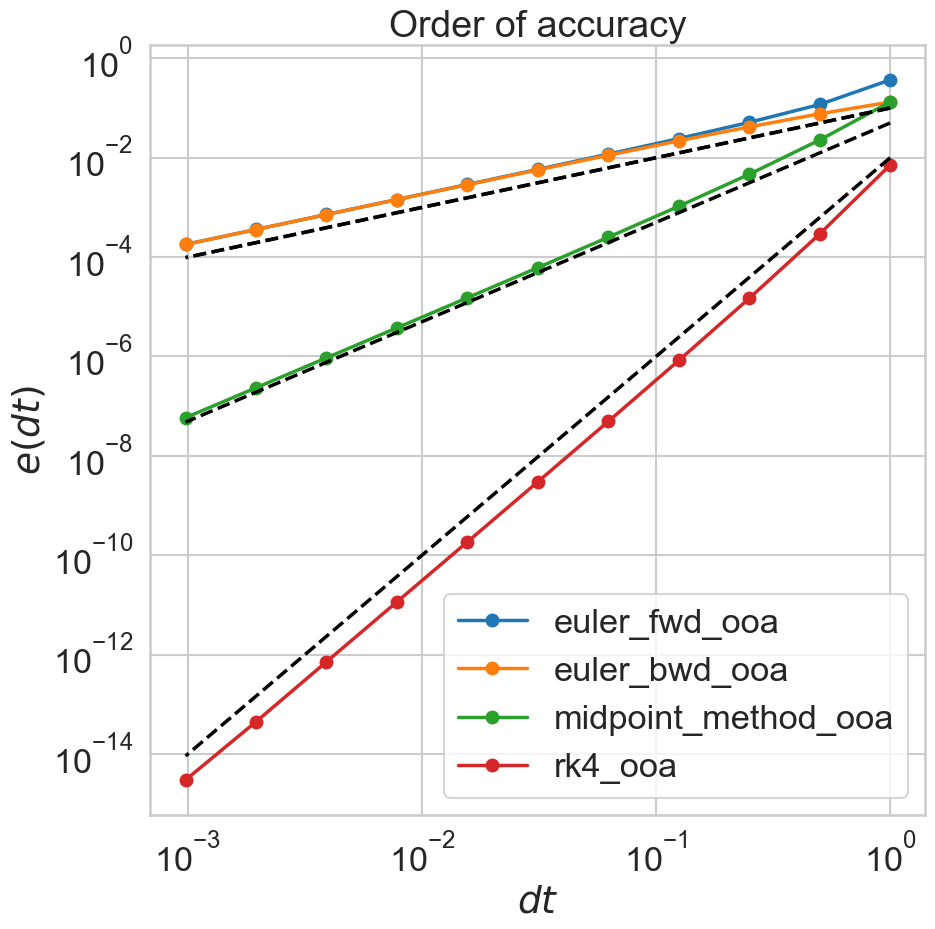

In [11]:
# Draw error plots in a log-log plot
fig, ax = plt.subplots(1,1, figsize=(10, 10))

# x axis is time, y axis is error
for i_func, func in enumerate(func_list):
    ax.plot((2.)**(-dt_steps), errors_list[i_func], 'o-', label=func.__name__)

# Draw helpful slope lines to compare
slopes_list = [None for func in func_list]
slopes_list[0] = 0.1 * (2.)**(-dt_steps)
slopes_list[1] = 0.1 * (2.)**(-dt_steps)
slopes_list[2] = 0.05 * (2.)**(-2*dt_steps)
slopes_list[3] = 0.01 * (2.)**(-4*dt_steps)

for slope_lines in slopes_list:
    ax.plot((2.)**(-dt_steps), slope_lines, 'k--')

# Make it readable
ax.set_xlabel(r'$dt$')
ax.set_ylabel(r'$e(dt)$')
ax.set_title('Order of accuracy')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()


# fig.savefig('ooa.pdf')

# Save data if you need to plot it in another application
SAVE_FLAG = True

if SAVE_FLAG:
    import os
    DATA_PATH = os.path.join(os.getcwd(),'data')
    if not os.path.isdir(DATA_PATH):
        os.makedirs(DATA_PATH)

    for i_func, func in enumerate(func_list):
        data_arr = np.vstack(((2.)**(-dt_steps), np.array(errors_list[i_func])))
        np.savetxt(os.path.join(DATA_PATH, func.__name__ + '.txt'), data_arr.T, delimiter='\t')
        data_arr = np.vstack(((2.)**(-dt_steps), (slopes_list[i_func])))
        np.savetxt(os.path.join(DATA_PATH, func.__name__ + '_slopes.txt'), data_arr.T, delimiter='\t')
        # print(data_arr.shape)
        # ax.plot((2.)**(-dt_steps), errors_list[i_func], 'o-', label=func.__name__)

Some questions to ponder about
- How do you interpret this diagram?
- Are these schemes robust to coding errors (i.e. replace `x` by `x*` and see what happens)
- Are these bound to exhibit the same behavior, irrespective of $f$?

## Symmetry/Symplectic/Energy preserving characteristics 
### Harmonic oscillator
Let's consider the equations governing the dynamics of the harmonic oscillator next. What are harmonic oscillators? 

Any undamped linear spring-mass system! (*This statement is not completely true, but for this class it is*).
![Springmass](https://i.stack.imgur.com/ny3Qc.gif "springmass")
(Credits: User `kma`, https://tex.stackexchange.com/a/58448)

This system is modeled by $\ddot{x} + x = 0$ (parameters are normalized). We first decompose this second order ODE to a system of two first order ODEs (so that we can use the same first order ODE machinery seen before) by introducing the transformation $ y = \dot{x} $ (If $x$ is the position, $y = \dot{x}$ indicates the velocity. Doing so gives rise to the following linear system, whose dynamics in time we need to uncover:
$$ \begin{pmatrix} \dot{x} \\ \dot{y} \end{pmatrix} = \begin{bmatrix} 0 & 1\\-1 & 0 \end{bmatrix} \begin{pmatrix} {x} \\ {y} \end{pmatrix} $$
wherein we consider the initial conditions to be $ x(0) = 1, y(0) = \dot{x}(0) = 0 $. The analytical solution of this system of ODEs is $ x(t) = \cos(t), y(t) = -\sin(t) $, as seen in class. Notice that if we draw the phase plane of position (in x-axis) and velocity (in y-axis), then 
$$ x^2(t) + y^2(t) \equiv 1$$


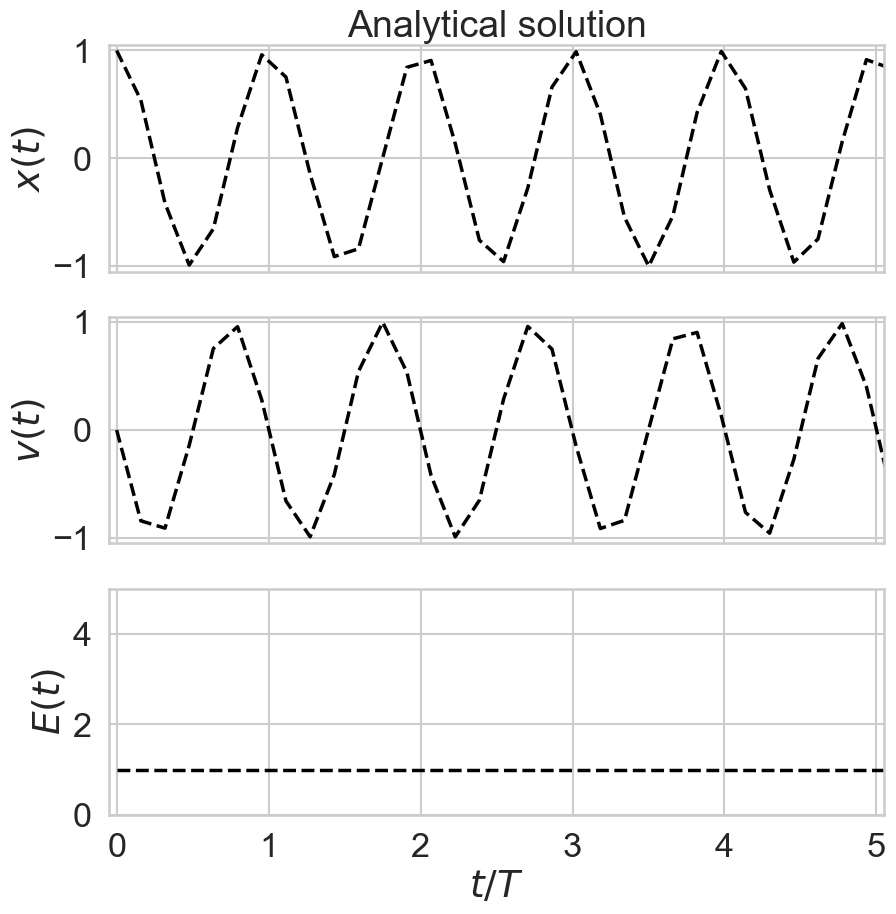

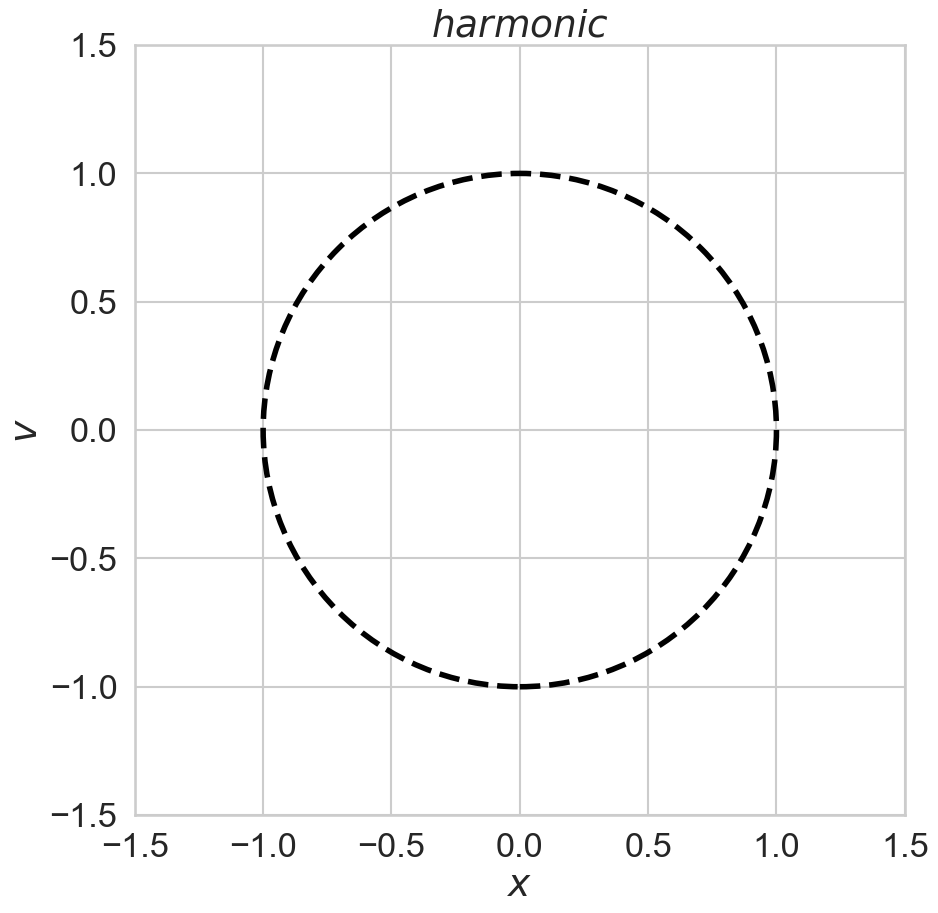

In [12]:
i_x = [1.0]
i_v = [0.0]

# # First set, fine
dt = 1.0
f_T = 62.8

# Second set, very coarse
# dt = 5.0
# f_T = 628.0

fig2, ax2_list = plt.subplots(3,1, figsize=(10, 10), sharex=True)
fig, ax = plt.subplots(1,1, figsize=(10, 10))
a = TimeStepper(i_x, i_v, dt, f_T)
a.set_forcing_function('harmonic')
a.draw(ax)
a.draw_sol(ax2_list)
# fig.savefig('true_solution.pdf')

### Euler's forward method
For a system of ODEs

In [13]:
# Question
def euler_fwd(dt, x, v, force_rule):
    """Does one iteration/timestep using the Euler forward scheme
    
    Parameters
    ----------
    dt : float
        Simulation timestep in seconds
    x : float/array-like
        Quantity of interest / position of COM
    v : float/array-like
        Quantity of interest / velocity of COM
    force_rule : ufunc
        A function, f, that takes one argument and
        returns the instantaneous forcing

    Returns
    -------
    x_n : float/array-like
        The quantity of interest at the Next time step
    v_n : float/array-like
        The quantity of interest at the Next time step
    """
    x_n = x
    v_n = v
    return x_n, v_n

a.timestep_using(euler_fwd)

In [14]:
# Answer
def euler_fwd(dt, x, v, force_rule):
    """Does one iteration/timestep using the Euler forward scheme
    
    Parameters
    ----------
    dt : float
        Simulation timestep in seconds
    x : float/array-like
        Quantity of interest / position of COM
    v : float/array-like
        Quantity of interest / velocity of COM
    force_rule : ufunc
        A function, f, that takes one argument and
        returns the instantaneous forcing

    Returns
    -------
    x_n : float/array-like
        The quantity of interest at the Next time step
    v_n : float/array-like
        The quantity of interest at the Next time step
    """
    x_n = x + dt * v
    v_n = v + dt * force_rule(x)
    return x_n, v_n

a.timestep_using(euler_fwd)

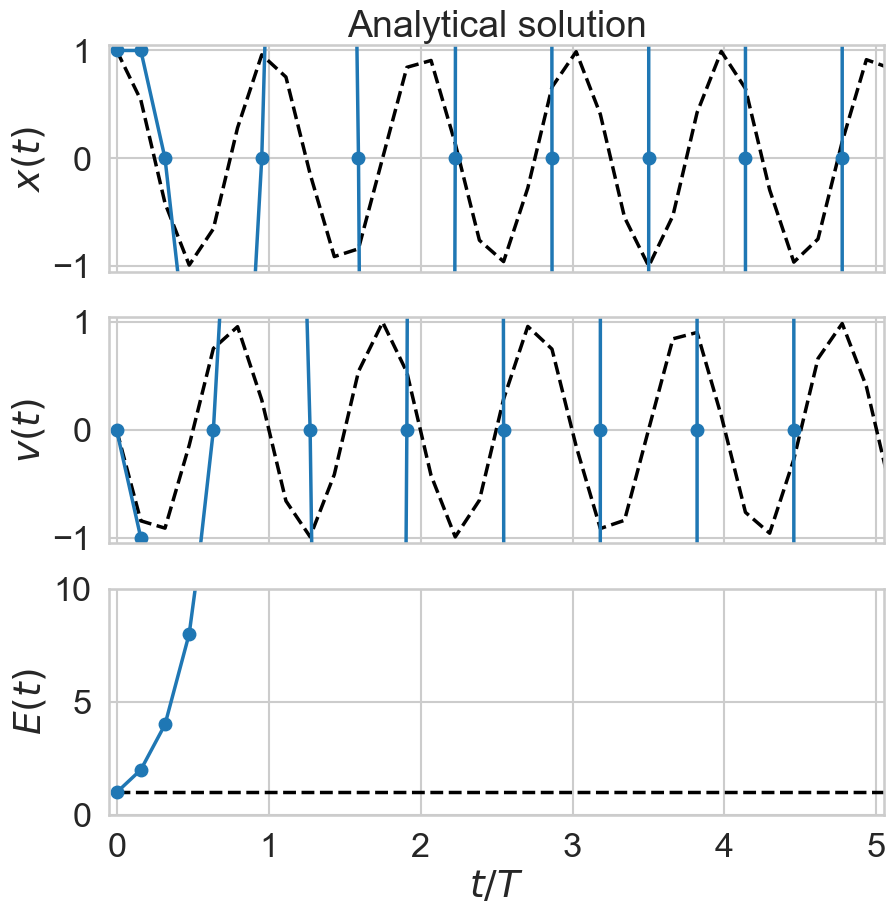

In [15]:
a.draw_sol(ax2_list)
fig2

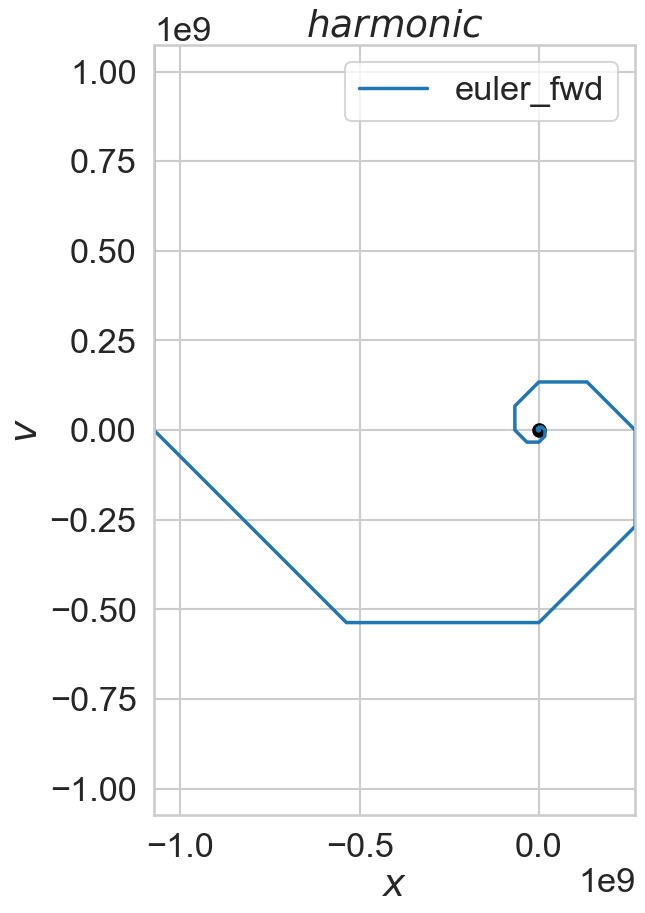

In [16]:
a.draw(ax)
fig
# fig.savefig('euler_fwd_1.0.pdf')

### Position verlet scheme for second order ODE
$$ \begin{align}
	\mathbf{x}^* &= \mathbf{x}^n + 0.5\cdot dt \cdot \mathbf{y}^n \\
	\mathbf{y}^{n+1} &= \mathbf{y}^n + dt \cdot \mathbf{f}\left( \mathbf{x}^*\right) \\
	\mathbf{x}^{n+1} &= \mathbf{x}^* + 0.5\cdot dt \cdot \mathbf{y}^{n+1}
\end{align} $$
We only have **one** functional evaluation, while obtaining **second**-order accuracy in position and velocity.

In [17]:
# Question
def position_verlet(dt, x, v, force_rule):
    """Does one iteration/timestep using the Position verlet scheme
    
    Parameters
    ----------
    dt : float
        Simulation timestep in seconds
    x : float/array-like
        Quantity of interest / position of COM
    v : float/array-like
        Quantity of interest / velocity of COM
    force_rule : ufunc
        A function, f, that takes one argument and
        returns the instantaneous forcing

    Returns
    -------
    x_n : float/array-like
        The quantity of interest at the Next time step
    v_n : float/array-like
        The quantity of interest at the Next time step
    """
    v_n = v
    x_n = x
    return x_n, v_n

a.timestep_using(position_verlet)

In [18]:
# Answer
def position_verlet(dt, x, v, force_rule):
    """Does one iteration/timestep using the Position verlet scheme
    
    Parameters
    ----------
    dt : float
        Simulation timestep in seconds
    x : float/array-like
        Quantity of interest / position of COM
    v : float/array-like
        Quantity of interest / velocity of COM
    force_rule : ufunc
        A function, f, that takes one argument and
        returns the instantaneous forcing

    Returns
    -------
    x_n : float/array-like
        The quantity of interest at the Next time step
    v_n : float/array-like
        The quantity of interest at the Next time step
    """
    temp_x = x + 0.5*dt*v
    v_n = v + dt * force_rule(temp_x)
    x_n = temp_x + 0.5 * dt * v_n
    return x_n, v_n

a.timestep_using(position_verlet)

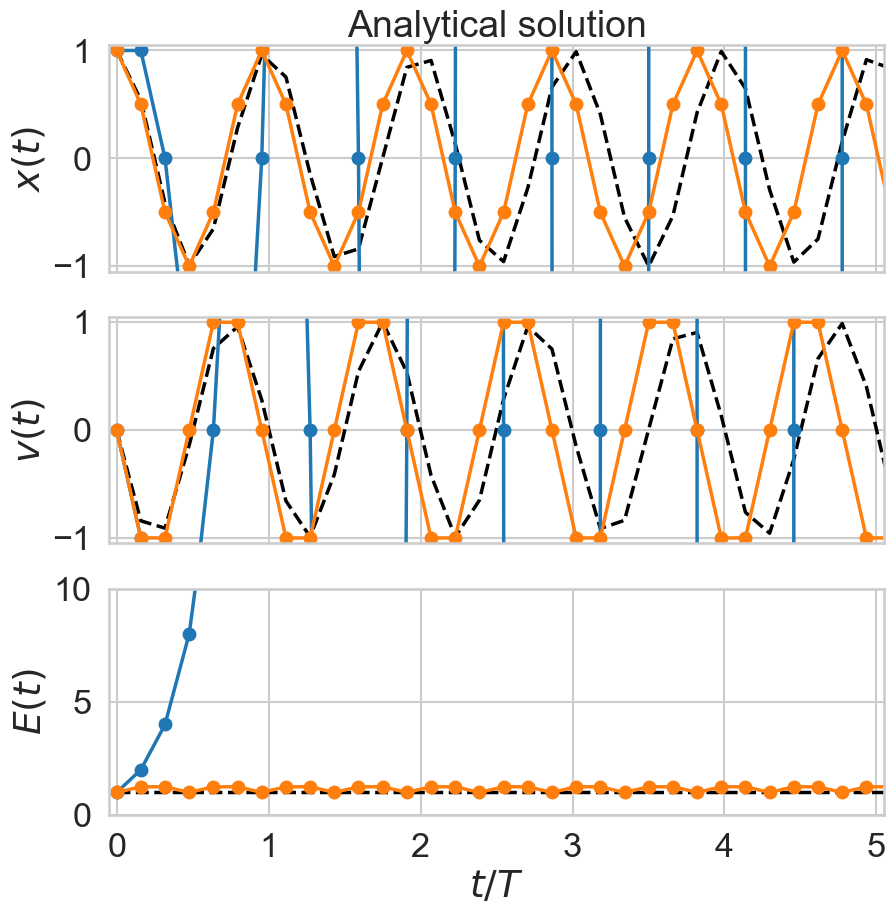

In [19]:
a.draw_sol(ax2_list)
fig2

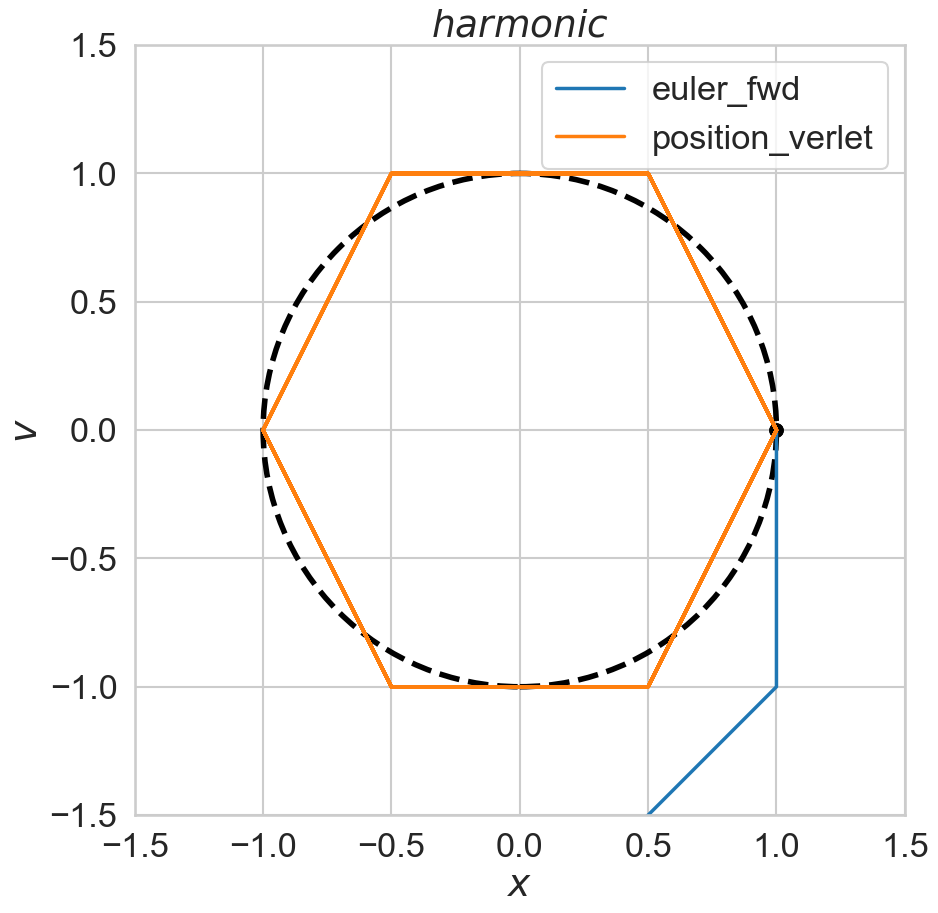

In [20]:
a.draw(ax)
fig

### Velocity verlet scheme for second order ODE
$$ \begin{align}
	\mathbf{y}^* &= \mathbf{y}^n + 0.5\cdot dt \cdot \mathbf{f}\left( \mathbf{x}^n\right) \\
	\mathbf{x}^{n+1} &= \mathbf{x}^{n} + dt \cdot \mathbf{y}^{*} \\
\mathbf{y}^{n+1} &= \mathbf{y}^* + 0.5\cdot dt \cdot \mathbf{f}\left( \mathbf{x}^{n+1}\right) \\
\end{align} $$
Note that we now have two functional evaluations, while retaining second-order accuracy in position and velocity.

In [21]:
# Question
def velocity_verlet(dt, x, v, force_rule):
    """Does one iteration/timestep using the Velocity verlet scheme
    
    Parameters
    ----------
    dt : float
        Simulation timestep in seconds
    x : float/array-like
        Quantity of interest / position of COM
    v : float/array-like
        Quantity of interest / velocity of COM
    force_rule : ufunc
        A function, f, that takes one argument and
        returns the instantaneous forcing

    Returns
    -------
    x_n : float/array-like
        The quantity of interest at the Next time step
    v_n : float/array-like
        The quantity of interest at the Next time step
    """
    x_n = x
    v_n = v
    return x_n, v_n

a.timestep_using(velocity_verlet)

In [22]:
# Answer
def velocity_verlet(dt, x, v, force_rule):
    """Does one iteration/timestep using the Velocity verlet scheme
    
    Parameters
    ----------
    dt : float
        Simulation timestep in seconds
    x : float/array-like
        Quantity of interest / position of COM
    v : float/array-like
        Quantity of interest / velocity of COM
    force_rule : ufunc
        A function, f, that takes one argument and
        returns the instantaneous forcing

    Returns
    -------
    x_n : float/array-like
        The quantity of interest at the Next time step
    v_n : float/array-like
        The quantity of interest at the Next time step
    """
    temp_v = v + 0.5*dt*force_rule(x)
    x_n = x + dt * temp_v
    v_n = temp_v + 0.5* dt * force_rule(x_n)
    return x_n, v_n

a.timestep_using(velocity_verlet)

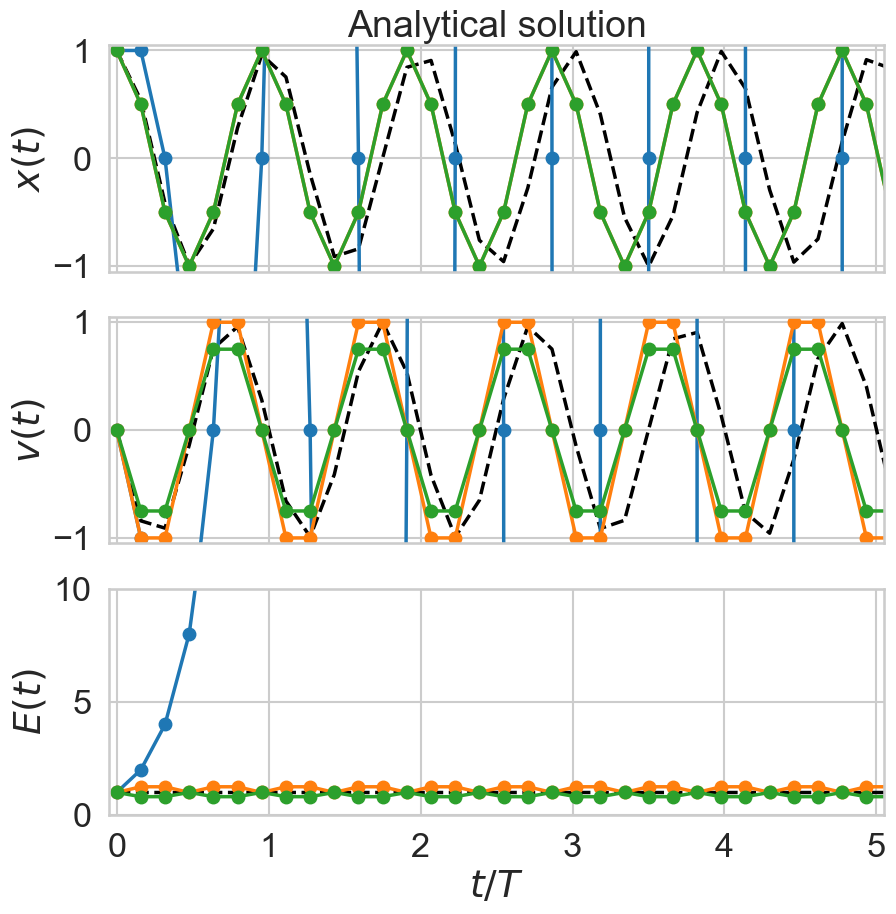

In [23]:
a.draw_sol(ax2_list)
fig2

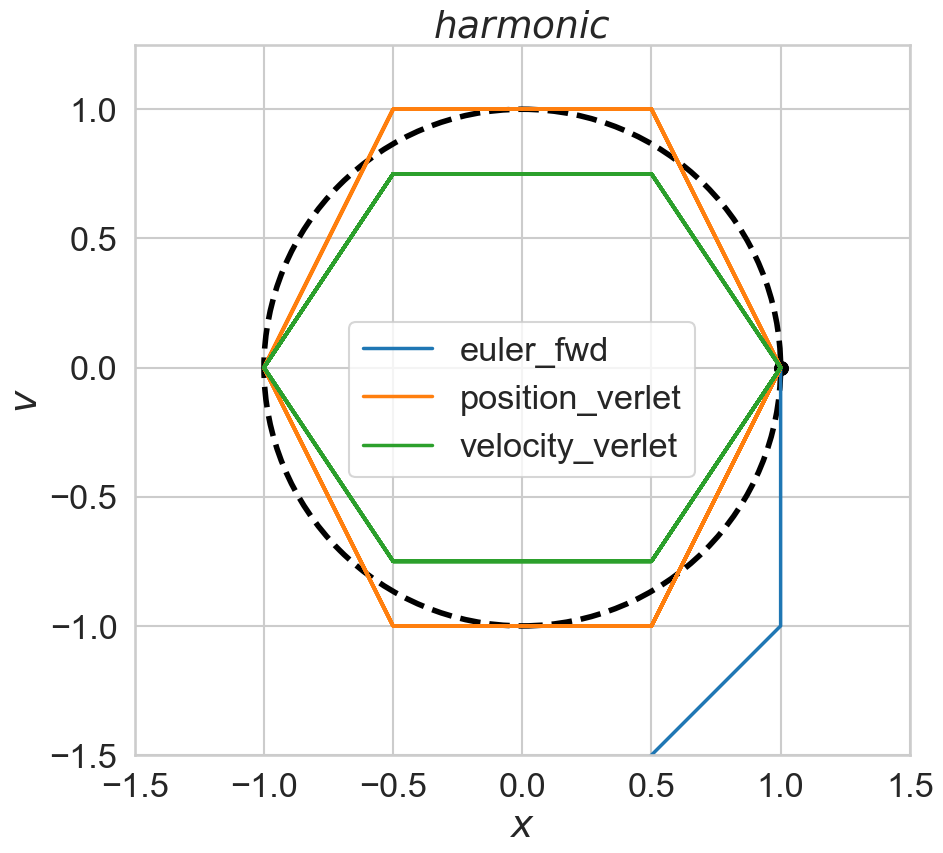

In [24]:
a.draw(ax)
fig

### Euler-Cromer scheme
The second variant of semi-implicit Euler/Euler-Cromer scheme is
$$ \begin{align}
\mathbf{x}^{n+1} &= \mathbf{x}^{n} + dt \cdot \mathbf{y}^{n+1} \\
\mathbf{y}^{n+1} &= \mathbf{y}^{n} + dt \cdot \mathbf{f}\left( \mathbf{x}^{n+1}\right) \\
\end{align} $$

In [25]:
# Question
def euler_cromer(dt, x, v, force_rule):
    """Does one iteration/timestep using the Euler Cromer scheme
    
    Parameters
    ----------
    dt : float
        Simulation timestep in seconds
    x : float/array-like
        Quantity of interest / position of COM
    v : float/array-like
        Quantity of interest / velocity of COM
    force_rule : ufunc
        A function, f, that takes one argument and
        returns the instantaneous forcing

    Returns
    -------
    x_n : float/array-like
        The quantity of interest at the Next time step
    v_n : float/array-like
        The quantity of interest at the Next time step
    """
    x_n = x
    v_n = v
    return x_n, v_n

# a.timestep_using(euler_cromer)

In [26]:
# Answer
def euler_cromer(dt, x, v, force_rule):
    """Does one iteration/timestep using the Euler Cromer scheme
    
    Parameters
    ----------
    dt : float
        Simulation timestep in seconds
    x : float/array-like
        Quantity of interest / position of COM
    v : float/array-like
        Quantity of interest / velocity of COM
    force_rule : ufunc
        A function, f, that takes one argument and
        returns the instantaneous forcing

    Returns
    -------
    x_n : float/array-like
        The quantity of interest at the Next time step
    v_n : float/array-like
        The quantity of interest at the Next time step
    """
    x_n = x + dt * v
    v_n = v + dt * force_rule(x_n)
    return x_n, v_n

# a.timestep_using(euler_cromer)

### Runge Kutta-4
For a system of ODEs. Repeated again for convenience
$$ \begin{align}
	\mathbf{k}_1 &= \mathbf{f}(\mathbf{x}^{n}) \cdot dt \\
	\mathbf{k}_2 &= \mathbf{f}(\mathbf{x}^{n} + 0.5 \cdot \mathbf{k}_1)\cdot dt \\
	\mathbf{k}_3 &= \mathbf{f}(\mathbf{x}^{n} + 0.5 \cdot \mathbf{k}_2)\cdot dt \\
	\mathbf{k}_4 &= \mathbf{f}(\mathbf{x}^{n} + \mathbf{k}_3)\cdot dt \\
	\mathbf{x}^{n+1} &= \mathbf{x}^{n} + \frac{\mathbf{k}_1+2\mathbf{k}_2+2\mathbf{k}_3+\mathbf{k}_4}{6}
\end{align} $$

In [27]:
# Question
def runge_kutta4(dt, x, v, force_rule):
    """Does one iteration/timestep using the RK4 scheme
    
    Parameters
    ----------
    dt : float
        Simulation timestep in seconds
    x : float/array-like
        Quantity of interest / position of COM
    v : float/array-like
        Quantity of interest / velocity of COM
    force_rule : ufunc
        A function, f, that takes one argument and
        returns the instantaneous forcing

    Returns
    -------
    x_n : float/array-like
        The quantity of interest at the Next time step
    v_n : float/array-like
        The quantity of interest at the Next time step
    """
    x_n, v_n = x, v   
    return x_n, v_n

a.timestep_using(runge_kutta4)

In [28]:
# Answer
def runge_kutta4(dt, x, v, force_rule):
    """Does one iteration/timestep using the RK4 scheme
    
    Parameters
    ----------
    dt : float
        Simulation timestep in seconds
    x : float/array-like
        Quantity of interest / position of COM
    v : float/array-like
        Quantity of interest / velocity of COM
    force_rule : ufunc
        A function, f, that takes one argument and
        returns the instantaneous forcing

    Returns
    -------
    x_n : float/array-like
        The quantity of interest at the Next time step
    v_n : float/array-like
        The quantity of interest at the Next time step
    """
    
    def vector_func(y):
        return np.array([y[1], force_rule(y[0])])

    # Base
    u = np.array([x,v])

    # Stage 1
    k_1 = dt*vector_func(u)

    # Stage 2
    k_2 = dt * vector_func(u + 0.5*k_1)

    # Stage 3
    k_3 = dt * vector_func(u + 0.5*k_2)

    # Stage 4
    k_4 = dt * vector_func(u + k_3)

    u_n = u + (1./6.)*(k_1 + 2.*k_2 + 2.* k_3 + k_4)
    
    return u_n[0], u_n[1]

a.timestep_using(runge_kutta4)

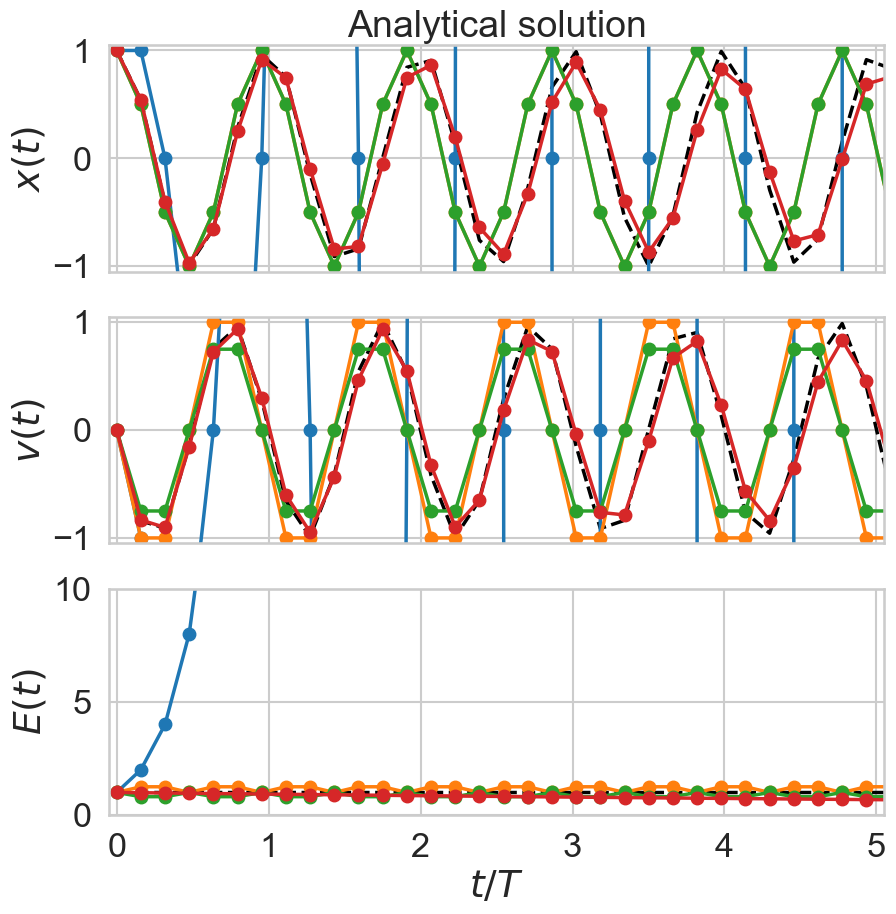

In [29]:
a.draw_sol(ax2_list)
fig2

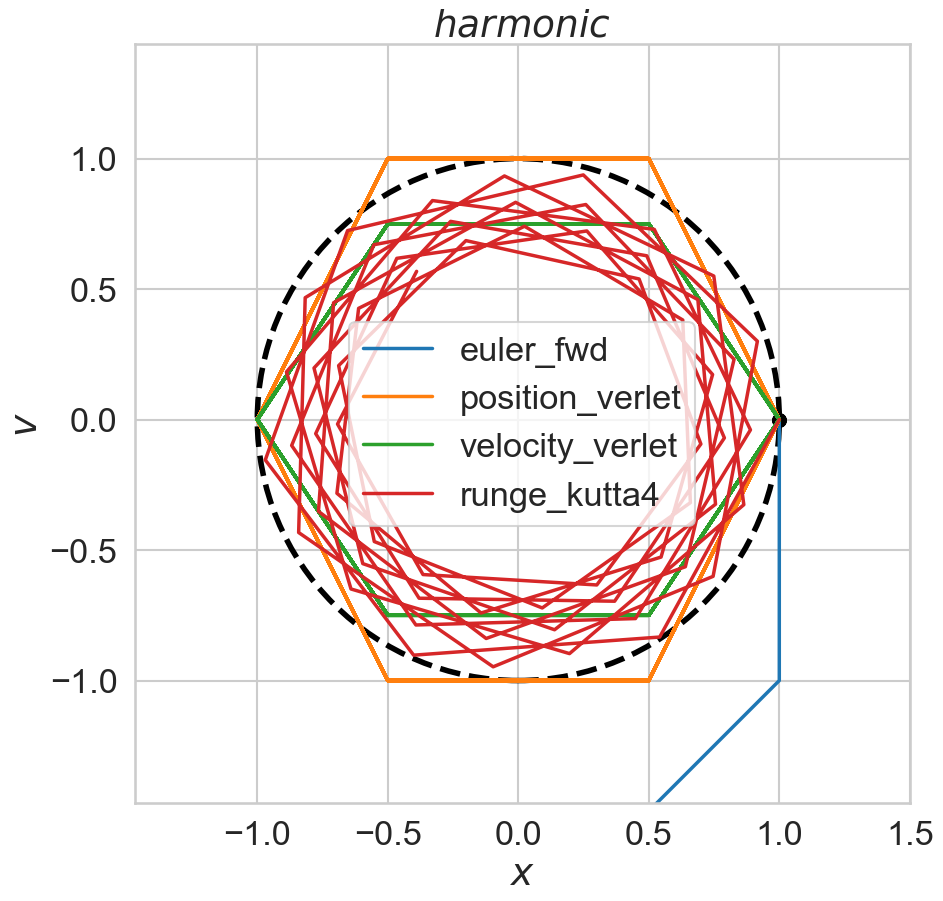

In [30]:
a.draw(ax)
fig
# fig.savefig('rk4_1.0.pdf')

Some questions to ponder about
- What do you observe as you increase \( dt \) in all cases?
- Are symplectic schemes perfect in its descrption of physics?

# Video of the maps, please ignore

NameError: name 'ax2' is not defined

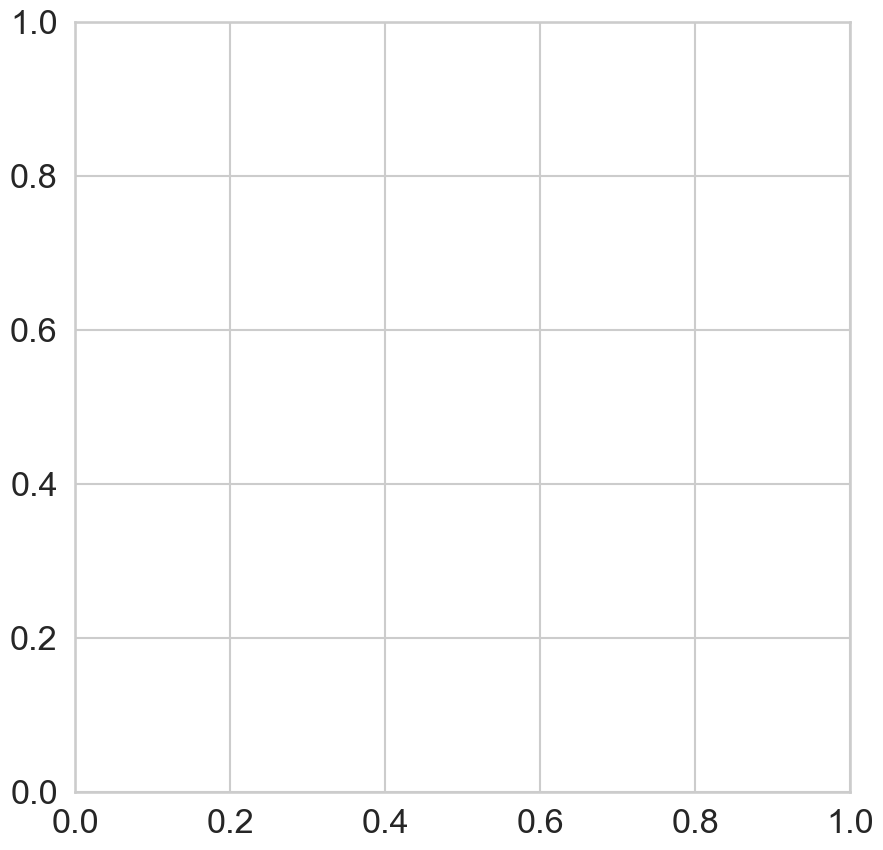

In [31]:
fig3, ax3 = plt.subplots(1,1, figsize=(10, 10))
i_x = [0.0]
i_v = [1.0]
dt = 1.0
f_T = 700.0
b = TimeStepper(i_x, i_v, dt, f_T)
b.set_forcing_function('harmonic')
b.draw(ax2)
b.timestep_using(position_verlet)
ax3.set_xlim([-1.5, 1.5])
ax3.set_ylim([-1.5, 1.5])
#b.draw(ax2)
# fig2

In [ ]:
cmap = sns.color_palette()
verlet_color = cmap[0]
rk_color = cmap[2]
anim = b.animate(fig3, ax3, verlet_color)

In [ ]:
HTML(anim.to_jshtml())

In [ ]:
# anim.save('verlet.mp4', fps=30, 
#           extra_args=['-vcodec', 'h264', 
#                       '-pix_fmt', 'yuv420p'])